# Imports

In [16]:
import numpy as np
import pandas as pd
# print(check_output(["ls", "../input"]).decode("utf8"))

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.models import load_model
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD

import seaborn as sns
from glob import glob
from PIL import Image
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from subprocess import check_output
import warnings
from os.path import split

warnings.filterwarnings("ignore",category=DeprecationWarning)

# Read in the Images

In [17]:
train_images = glob("../input/whale-categorization-playground/train/*jpg")
test_images = glob("../input/whale-categorization-playground/test/*jpg")
df = pd.read_csv("../input/whale-categorization-playground/train.csv")

df = df[df['Id'] != 'new_whale']

df["Image"] = df["Image"].map( lambda x : "../input/whale-categorization-playground/train/"+x)
ImageToLabelDict = dict( zip( df["Image"], df["Id"]))
ImageToLabelDict = { k:v for k, v in ImageToLabelDict.items() if v != 'new_whale' }
train_images = list(ImageToLabelDict.keys())

In [18]:
SIZE = 128
#image are imported with a resizing and a black and white conversion
def ImportImage( filename):
    img = Image.open(filename).convert("LA").resize( (SIZE,SIZE))
    return np.array(img)[:,:,0]
X_train = np.array([ImportImage( img) for img in train_images])

In [19]:
class LabelOneHotEncoder():
    def __init__(self):
        self.ohe = OneHotEncoder()
        self.le = LabelEncoder()
    def fit_transform(self, x):
        features = self.le.fit_transform( x)
        return self.ohe.fit_transform( features.reshape(-1,1))
    def transform( self, x):
        return self.ohe.transform( self.la.transform( x.reshape(-1,1)))
    def inverse_tranform( self, x):
        return self.le.inverse_transform( self.ohe.inverse_tranform( x))
    def inverse_labels( self, x):
        return self.le.inverse_transform( x)

Y_train = list(map(ImageToLabelDict.get, train_images))
lohe = LabelOneHotEncoder()
Y_train = lohe.fit_transform(Y_train).toarray()

# Plot Some Samples

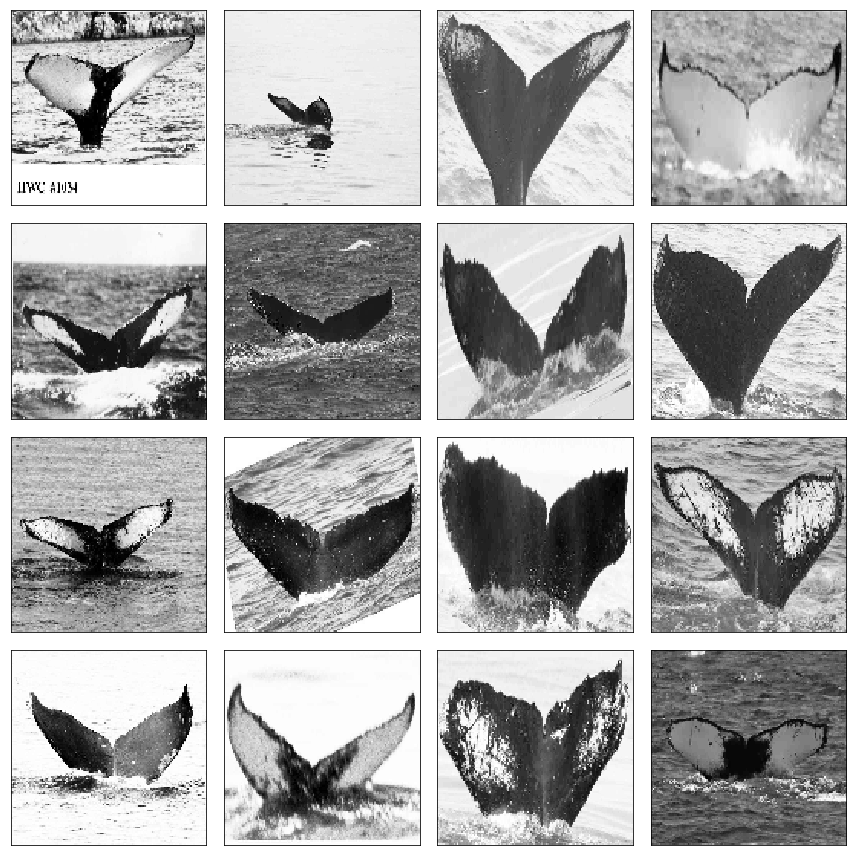

In [20]:
def plotImages( images_arr, n_images=4):
    fig, axes = plt.subplots(n_images, n_images, figsize=(12,12))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        if img.ndim != 2:
            img = img.reshape( (SIZE,SIZE))
        ax.imshow( img, cmap="Greys_r")
        ax.set_xticks(())
        ax.set_yticks(())
    plt.tight_layout()
    
plotImages( X_train)

# Data Augmentation

In [21]:
X_train = X_train.reshape( (-1,SIZE,SIZE,1)).astype("float32")
N_CLASSES = len(Y_train[0])

image_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range = 0.05,
    shear_range=0.02,
    channel_shift_range=0.02,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

image_gen.fit(X_train, augment=True)

# Building the Model

In [22]:

model = Sequential()
model.add(Conv2D(128, kernel_size=(7, 7),
                 activation='relu',
                 input_shape=X_train[0].shape, padding='same'))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(64, (4, 4), activation='relu', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.1))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (2, 2), activation='relu', padding='same'))
model.add(BatchNormalization(axis=3))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (2, 2), activation='relu', padding='same'))
model.add(BatchNormalization(axis=3))
model.add(AveragePooling2D(pool_size=(4, 4)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(N_CLASSES, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 128, 128)     6400      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 64)      204864    
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 64)        65600     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 64, 64, 32)        18464     
__________

In [23]:
# model = load_model("../input/whale-weights/full_train_model.hdf5")

In [24]:
%%time
EPOCHS = 200
BATCH_SIZE = 128

model.fit_generator(image_gen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
          steps_per_epoch=  (X_train.shape[0]//BATCH_SIZE),
          epochs=EPOCHS,
          verbose=2)

Epoch 1/1
 - 105s - loss: 8.2999 - acc: 0.0030
CPU times: user 1min 14s, sys: 27.2 s, total: 1min 41s
Wall time: 1min 46s


In [ ]:
model.save_weights("full_train_weights.hdf5")
model.save("full_train_model.hdf5")

# Predict on Test Images

In [ ]:
%%time

sample = pd.read_csv("../input/whale-categorization-playground/sample_submission.csv")

def PredictImages(line):
    image = '../input/whale-categorization-playground/test/' + line[0]
    img = ImportImage( image)
    x = img.astype( "float32")
    x = image_gen.standardize( x.reshape(1,SIZE,SIZE))

    y = model.predict_proba(x.reshape(1,SIZE,SIZE,1))
    predicted_args = np.argsort(y)[0][::-1][:5]
    predicted_tags = lohe.inverse_labels( predicted_args)
    image = split(image)[-1]
    predicted_tags_with_new_whale = 'new_whale '+" ".join( predicted_tags[:-1])
    return predicted_tags_with_new_whale

sample['Id'] = sample[['Image']].apply(PredictImages, axis = 1)

In [ ]:
sample[:10]

In [ ]:
sample.to_csv("Whale_CNN_SuperCharged.csv", index=False, header=True)